# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

In addition to implementing code, there is a brief writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) that can be used to guide the writing process. Completing both the code in the Ipython notebook and the writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/322/view) for this project.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="examples/line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="examples/laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

**Run the cell below to import some packages.  If you get an `import error` for a package you've already installed, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt.  Also, consult the forums for more troubleshooting tips.**  

## Import Packages

In [25]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import os
%matplotlib inline

## Read in an Image

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


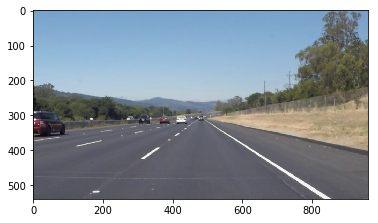

In [26]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

## Ideas for Lane Detection Pipeline

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

## Helper Functions

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [27]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

def mask_yellow_white(image):
    """ Mask yellow and white using HSV (hue, saturation, value) """
    gray = grayscale(image)
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    lower_yellow = np.array([20, 100, 100], dtype = "uint8")
    upper_yellow = np.array([30, 255, 255], dtype="uint8")

    mask_yellow = cv2.inRange(hsv, lower_yellow, upper_yellow)
    mask_white = cv2.inRange(gray, 200, 255)
    mask_yellow_white = cv2.bitwise_or(mask_white, mask_yellow)
    return cv2.bitwise_and(gray, mask_yellow_white)

def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def roi_shape(shape):
    """ Calculate region of interest """
    left_down = [shape[1]/9, shape[0]]
    left_up = [shape[1]/2 - shape[1]/8, shape[0]/2 + shape[0]/10]
    right_up = [shape[1]/2 + shape[1]/8, shape[0]/2 + shape[0]/10]
    right_down = [shape[1] - shape[1]/9, shape[0]]
    return [np.array([left_down, left_up, right_up, right_down], dtype=np.int32)]

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    `vertices` should be a numpy array of integer points.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def get_slope(line):
    """ Calulate slope of a line """
    return (line[0][3] - line[0][1])/(line[0][2] - line[0][0])         

def get_bias(line, slope) :
    """ Calculate bias from line """
    return line[0][1] - (slope * line[0][0]) # b = y - mx

def get_y(x1, x2, slope, bias):
    """ get y coordinates by x, m, and m: y = mx + b """
    return int((slope * x1 ) + bias), int((slope * x2 ) + bias)

class Builder(object):
    """ Class for building lines """
    
    max_slope = 0.5 #to exclude horizontal lines
    
    def __init__(self, shape):
        self.left_slope, self.right_slope = [], []
        self.left_line, self.right_line = [], []
        self.y_min = shape[0]
        self.y_max = shape[0]
        
    def add_line(self, line):
        self.y_min = min(line[0][1], line[0][3], self.y_min)
        slope = get_slope(line)
        if slope > self.max_slope and not math.isinf(slope):
            self.right_slope.append(slope)
            self.right_line.append(line)
        elif slope < -self.max_slope and not math.isinf(slope):
            self.left_slope.append(slope)
            self.left_line.append(line)
            
    def build_line(self, slope, line):
        m_slope = np.mean(slope)
        m_line = np.mean(np.array(line), axis=0)
        bias = get_bias(m_line, m_slope)    # b = y - mx
        y1 = self.y_min
        y2 = self.y_max
        x1 = int((y1 - bias)/m_slope) # x = (y-b)/m
        x2 = int((y2 - bias)/m_slope) # x = (y-b)/m  
        return m_slope, bias, x1, y1, x2, y2
    
    def build(self):
        if( (len(self.left_line) == 0) or (len(self.right_line) == 0) ):
            print ('Was not able to find lane')
            return None
        
        lslope, lbias, lx1, ly1, lx2, ly2 = self.build_line(self.left_slope, self.left_line)
        rslope, rbias, rx1, ry1, rx2, ry2 = self.build_line(self.right_slope, self.right_line)
    
        # if lines intersect
        if lx1 > rx1:
            lx1 = int((lx1 + rx1)/2)
            rx1 = lx1
            ly1, ly2 = get_y(lx1, lx2, lslope, lbias)
            ry1, ry2 = get_y(rx1, rx2, rslope, rbias)
      
        return np.array([lx1, ly1, lx2, ly2, rx1, ry1, rx2, ry2], dtype ="float32")

def draw_lines(img, lines, color=[255, 0, 0], thickness=3):
    """
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    if lines is None or len(lines) == 0: 
        print('Empty input')
        return 1

    global prev_frame
    
    builder = Builder(img.shape)
    for line in lines: builder.add_line(line)
        
    frame = builder.build()
    
    if frame is None: return 1
    
    prev_coef = 0.2 
    
    cur_frame = frame if prev_frame is None else (1 - prev_coef) * prev_frame + prev_coef * frame 
    prev_frame = cur_frame 
             
    cv2.line(img, (int(cur_frame[0]), int(cur_frame[1])), (int(cur_frame[2]),int(cur_frame[3])), color, thickness)
    cv2.line(img, (int(cur_frame[4]), int(cur_frame[5])), (int(cur_frame[6]),int(cur_frame[7])), color, thickness)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., γ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + γ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, γ)

In [28]:
def process_image(image):
    
    global prev_frame

    yw_masked_image = mask_yellow_white(image)

    kernel_size = 3
    gauss_image = gaussian_blur(yw_masked_image, kernel_size)

    low_threshold = 50
    high_threshold = 150
    canny_edges = canny(gauss_image, low_threshold, high_threshold)

    vertices = roi_shape(image.shape)
    roi_image = region_of_interest(canny_edges, vertices)

    rho = 4               # distance in Hough space
    theta = np.pi/180     # angular resolution of the grid in Hough space
    threshold = 30        # threshold is minimum number of intersections in a grid for candidate line to go to output
    min_line_len = 100
    max_line_gap = 180
    
    line_image = hough_lines(roi_image, rho, theta, threshold, min_line_len, max_line_gap)
    result = weighted_img(line_image, image, α=0.7, β=1., γ=1.)
    return result


## Test Images

Works well on 6 images with good light.
2 dacker images were added to test 

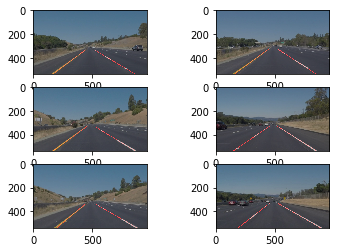

In [29]:
img_src_dir = "test_images/"
img_out_dir = "test_images_output/"
image_files = filter(lambda f: f.endswith("jpg"), os.listdir(img_src_dir))
for i, filename in enumerate(image_files):
    prev_frame = None
    image = mpimg.imread(img_src_dir + filename)
    processed = process_image(image)
    plt.subplot(3,2,i+1)
    plt.imshow(processed)
    mpimg.imsave(img_out_dir + "processed_"+ filename, processed)

## Build a Lane Finding Pipeline



Build the pipeline and run your solution on all test_images. Make copies into the `test_images_output` directory, and you can use the images in your writeup report.

Try tuning the various parameters, especially the low and high Canny thresholds as well as the Hough lines parameters.

In [30]:
# TODO: Build your pipeline that will draw lane lines on the test_images
# then save them to the test_images_output directory.

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!
We can test our solution on two provided videos:

`solidWhiteRight.mp4`
`solidYellowLeft.mp4`


In [31]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

Let's try the one with the solid white lane on the right first ...

In [32]:
prev_frame = None
white_output = 'test_videos_output/solidWhiteRight.mp4'
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) 
%time white_clip.write_videofile(white_output, audio=False)


[MoviePy] >>>> Building video test_videos_output/solidWhiteRight.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRight.mp4


100%|█████████▉| 221/222 [00:02<00:00, 77.52it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidWhiteRight.mp4 

CPU times: user 3.7 s, sys: 551 ms, total: 4.25 s
Wall time: 3.25 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [33]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [34]:
prev_frame = None
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidYellowLeft.mp4
[MoviePy] Writing video test_videos_output/solidYellowLeft.mp4


100%|█████████▉| 681/682 [00:09<00:00, 73.50it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidYellowLeft.mp4 

CPU times: user 11.7 s, sys: 1.7 s, total: 13.4 s
Wall time: 9.68 s


In [35]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [36]:
prev_frame = None
challenge_output = 'test_videos_output/challenge.mp4'
clip3 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip3.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/challenge.mp4
[MoviePy] Writing video test_videos_output/challenge.mp4


 65%|██████▍   | 163/251 [00:04<00:02, 36.00it/s]

Was not able to find lane
Was not able to find lane


100%|██████████| 251/251 [00:07<00:00, 35.11it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/challenge.mp4 

CPU times: user 7.54 s, sys: 1.44 s, total: 8.97 s
Wall time: 7.9 s


In [37]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))